In [2]:
from qiskit import *
import numpy as np
from qiskit_ibm_provider import IBMProvider

token='a2afa69f70955de3c84068e58c44bd81e01740c07ff40db7e9ab824c0da8b9412da7a86e9c453f7f97ecc35fc9f09948ce053cbd9e8213b98feadba15dcc467f'
#IBMQ.enable_account(token)
IBMProvider.save_account(token,overwrite=True)
provider = IBMProvider()
provider = IBMProvider(instance='ibm-q-ornl/ornl/csc517')
backend = provider.get_backend('ibm_algiers')
backend_config = backend.configuration()
pulse_alignment = backend_config.timing_constraints['pulse_alignment']

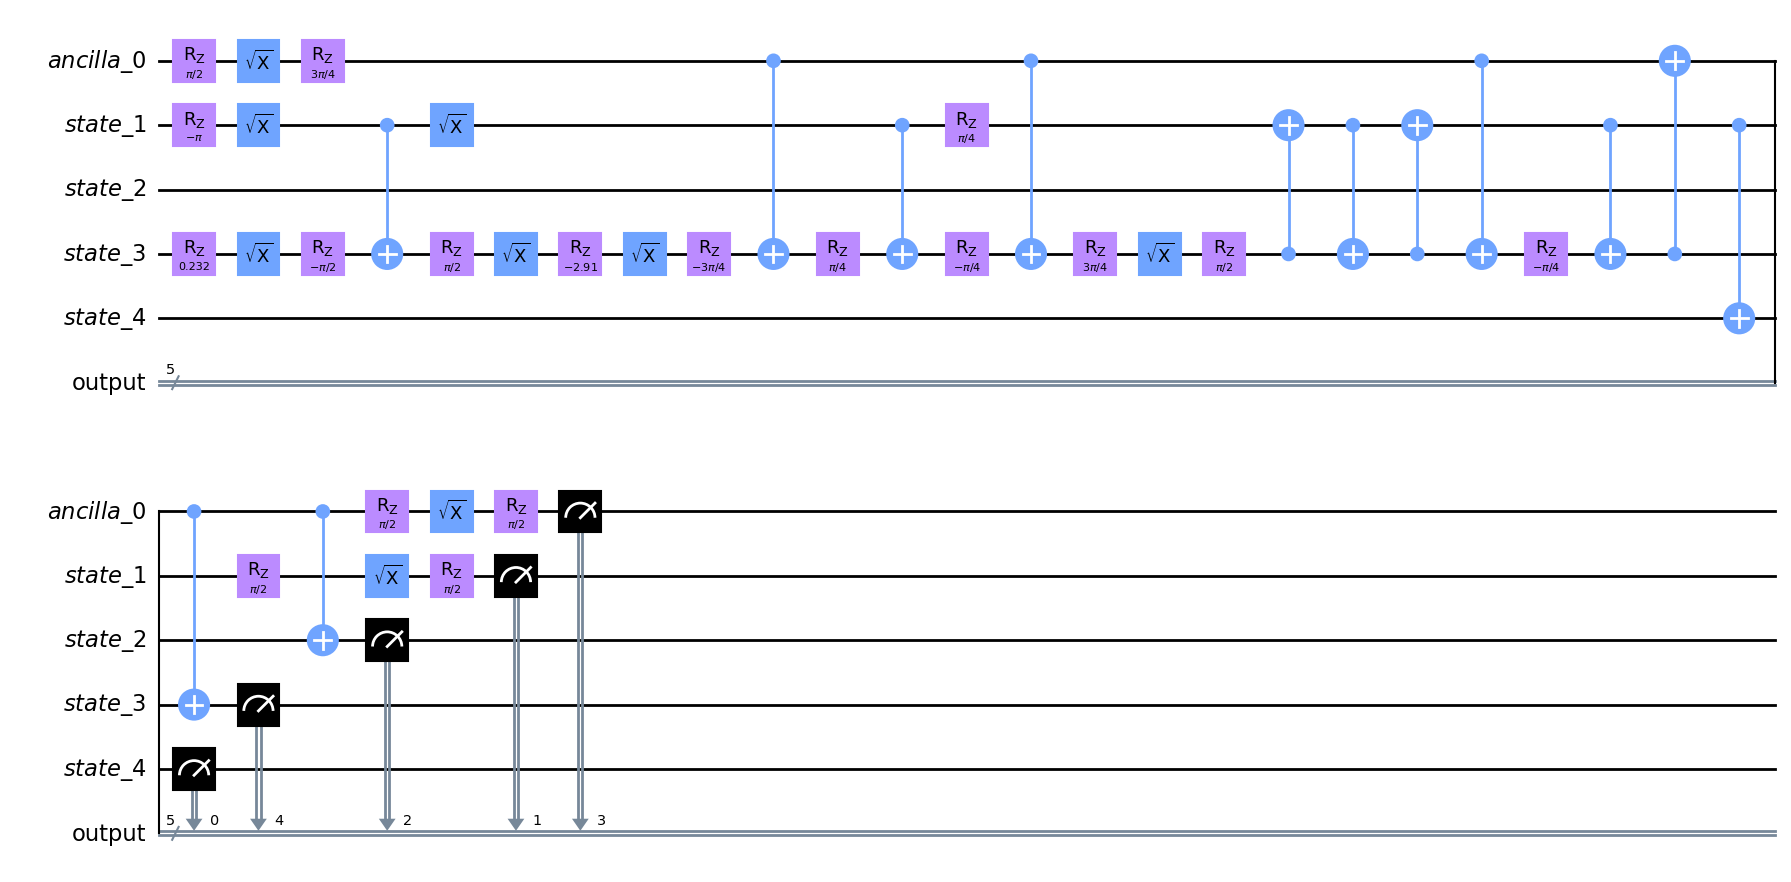

In [12]:
ancilla = QuantumRegister(1, 'ancilla_0')
A = QuantumRegister(1,'state_1')
B = QuantumRegister(1,'state_2')
C = QuantumRegister(1,'state_3')
D = QuantumRegister(1,'state_4')
Meas = ClassicalRegister(5,'output')

circuit = QuantumCircuit(ancilla, A, B, C, D, Meas)
circuit1 = QuantumCircuit(ancilla, A, B, C, D, Meas)

angle = 0.25*np.pi

circuit1.initialize([np.cos(1*angle/2),np.sin(1*angle/2)],B)
circuit1.initialize([np.cos(2*angle/2),np.sin(2*angle/2)],C)
circuit1.initialize([np.cos(3*angle/2),np.sin(3*angle/2)],D)

circuit.rz(1.5707963267948966, ancilla)
circuit.sx(ancilla)
circuit.rz(2.356194490192345, ancilla)
circuit.rz(0.23182380450040263, C)
circuit.sx(C)
circuit.rz(-1.5707963267948966, C)
circuit.rz(-3.141592653589793, A)
circuit.sx(A)
circuit.cx(A, C)
circuit.sx(A)
circuit.rz(1.5707963267948966, C)
circuit.sx(C)
circuit.rz(-2.9097688490893905, C)
circuit.sx(C)
circuit.rz(-2.3561944901923457, C)
circuit.cx(ancilla, C)
circuit.rz(0.7853981633974483, C)
circuit.cx(A, C)
circuit.rz(0.7853981633974483, A)
circuit.rz(-0.7853981633974483, C)
circuit.cx(ancilla, C)
circuit.rz(2.356194490192345, C)
circuit.sx(C)
circuit.rz(1.5707963267948966, C)
circuit.cx(C, A)
circuit.cx(A, C)
circuit.cx(C, A)
circuit.cx(ancilla, C)
circuit.rz(-0.7853981633974483, C)
circuit.cx(A, C)
circuit.cx(C, ancilla)
circuit.cx(ancilla, C)
circuit.cx(ancilla, B)
circuit.rz(1.5707963267948966, ancilla)
circuit.sx(ancilla)
circuit.rz(1.5707963267948966, ancilla)
circuit.cx(A, D)
circuit.rz(1.5707963267948966, A)
circuit.sx(A)
circuit.rz(1.5707963267948966, A)
circuit.measure(D, 0)
circuit.measure(A, 1)
circuit.measure(B, 2)
circuit.measure(ancilla, 3)
circuit.measure(C, 4)
    

circuit.draw(output='mpl')

In [13]:
from qiskit.circuit.library import XGate, HGate, RXGate, PhaseGate, TGate, TdgGate
from qiskit.transpiler.passmanager import PassManager
from qiskit.transpiler import target
from qiskit.transpiler.target import Target
from qiskit.transpiler.passes.scheduling import alap, asap, dynamical_decoupling
from qiskit.transpiler.passes.scheduling.scheduling.asap import ASAPScheduleAnalysis
#from qiskit.transpiler.passes.scheduling.scheduling import asap
from qiskit.transpiler.passes.scheduling.dynamical_decoupling import DynamicalDecoupling
from qiskit.transpiler.passes.optimization import CXCancellation, InverseCancellation

"""target = Target()
backend_durations = target.durations()
dd_sequence = [XGate(), XGate()]
scheduling_pm = PassManager([
    ALAPSchedule(backend_durations),
    DynamicalDecoupling(backend_durations, dd_sequence),
])

inverse_gate_list = [
    HGate(),
    (RXGate(np.pi / 4), RXGate(-np.pi / 4)),
    (PhaseGate(np.pi / 4), PhaseGate(-np.pi / 4)),
    (TGate(), TdgGate()),

]

pass_manager = PassManager([
    CXCancellation(),
    InverseCancellation([HGate(), (RXGate(np.pi / 4), RXGate(-np.pi / 4))])
])
    
# Add pre-layout stage to run extra logical optimization
pass_manager.pre_layout = logical_opt
# Set scheduling stage to custom pass manager
pass_manager.scheduling = scheduling_pm"""


layout = [1,7,0,4,6]

from qiskit.transpiler import target
from qiskit.transpiler.instruction_durations import InstructionDurations
from qiskit.transpiler.passes.scheduling.padding.dynamical_decoupling import PadDynamicalDecoupling

durations = InstructionDurations.from_backend(backend)

from qiskit.transpiler import target
#target_from_backend = Target().from_configuration(basis_gates = backend_config.basis_gates, num_qubits=backend_config.num_qubits, coupling_map=backend_config.coupling_map)


# Uhrig sequence (n=4) on busiest qubits 0,1,3
n = 4
dd_sequence1 = [XGate()] * n
def uhrig_pulse_location(k):
    return np.sin(np.pi * (k + 1) / (2 * n + 2)) ** 2
spacing1 = []
for k in range(n):
    spacing1.append(uhrig_pulse_location(k) - sum(spacing1))
spacing1.append(1 - sum(spacing1))

# Uhrig sequence (n=16) on idle qubits 2,4
n = 16
dd_sequence2 = [XGate()] * n
def uhrig_pulse_location(k):
    return np.sin(np.pi * (k + 1) / (2 * n + 2)) ** 2
spacing2 = []
for k in range(n):
    spacing2.append(uhrig_pulse_location(k) - sum(spacing2))
spacing2.append(1 - sum(spacing2))

scheduling_pm = PassManager(
    [
        ASAPScheduleAnalysis(durations),
        PadDynamicalDecoupling(durations, dd_sequence1, [layout[0],layout[1],layout[3]], spacing=spacing1, pulse_alignment=16),
        PadDynamicalDecoupling(durations, dd_sequence2, [layout[2],layout[4]], spacing=spacing2,skip_reset_qubits=False, pulse_alignment=16),
    ]
)
print(scheduling_pm.passes())

inverse_gate_list = [
    HGate(),
    (RXGate(np.pi/4), RXGate(-np.pi/4)),
    (PhaseGate(np.pi/4),PhaseGate(-np.pi/4)),
    (TGate(),TdgGate())
]

pass_manager = PassManager([
    CXCancellation(),
    InverseCancellation([HGate(),(RXGate(np.pi/4), RXGate(-np.pi/4))])
    
])

# Add pre-layout stage to run extra logical optimization
#pass_manager.pre_layout = logical_opt
# Set scheduling stage to custom pass manager
pass_manager.scheduling = scheduling_pm


if angle != 0:
    initialize = transpile(circuit1, backend, optimization_level=1, initial_layout=layout, seed_transpiler=42, routing_method='basic')
    Bellmeasure = transpile(circuit, backend, optimization_level=1, initial_layout=layout, seed_transpiler=42, routing_method='basic')
    final = initialize.compose(Bellmeasure)
else:
    final = transpile(circuit, backend, optimization_level=1, initial_layout=layout, seed_transpiler=42, routing_method='basic')

#final2 = transpile(final, backend, optimization_level=1, initial_layout=layout, seed_transpiler=42, routing_method='basic', scheduling_method='asap')
final_dd = scheduling_pm.run(final)
#final_dd.draw('mpl',cregbundle=False,idle_wires=False)


from qiskit.visualization.timeline import draw, IQXSimple

draw(final_dd, style=IQXSimple())

"""
shots = 50000
name = ['dd', (str(angle/np.pi)+'pi'),(str(shots/1000)+'k')]
from qiskit.visualization import timeline_drawer
#(final_dd,plotter='mpl',show_idle=False,time_range=[0,23000])
print(name)
"""

[{'passes': [<qiskit.transpiler.passes.scheduling.scheduling.asap.ASAPScheduleAnalysis object at 0x000001759E5459F0>, <qiskit.transpiler.passes.scheduling.padding.dynamical_decoupling.PadDynamicalDecoupling object at 0x000001759F6B50C0>, <qiskit.transpiler.passes.scheduling.padding.dynamical_decoupling.PadDynamicalDecoupling object at 0x000001759F6B7370>], 'flow_controllers': {}}]


"\nshots = 50000\nname = ['dd', (str(angle/np.pi)+'pi'),(str(shots/1000)+'k')]\nfrom qiskit.visualization import timeline_drawer\n#(final_dd,plotter='mpl',show_idle=False,time_range=[0,23000])\nprint(name)\n"

In [120]:

job = backend.run(final_dd,shots=shots)
job.update_tags(name)

['0.5pi', 'dd', '50.0k']